In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import warnings

# Disable the specific warning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
# Load Feature File
DATA_ROOT = "/Users/andrewgrowney/Data/kaggle/marchmadness-2024"
df = pd.read_csv("../TeamSeasons_cust.csv")
reg_season_df = pd.read_csv(f"{DATA_ROOT}/MRegularSeasonCompactResults.csv")
reg_season_df = reg_season_df[reg_season_df.Season >= 2003]
tournament_results_df = pd.read_csv(f"{DATA_ROOT}/MNCAATourneyCompactResults.csv")
tournament_results_df = tournament_results_df[tournament_results_df.Season >= 2003]

# Win Probability: Difference of Stats
Model type: Simple Binary Classification

Input: [FGPct_diff, ..., feat_diff_n] (e.g. FGPct_diff = t1.FGPct_mean - t2.FGPct_mean)

Output: 0 -> team 1 wins, 1 -> team 2 wins

In [11]:
def get_diff(df:pd.DataFrame, t1_id:int, t2_id:int, season:int, features:List[str]):
    t1 = df[(df['TeamID'] == t1_id) & (df['Season'] == season)][features].fillna(0)
    t2 = df[(df['TeamID'] == t2_id) & (df['Season'] == season)][features].fillna(0)
    diff = t1.values - t2.values
    return diff[0]

In [3]:
ks_ark = get_diff(df, 1104, 1113, 2023, ['FGM_mean', 'FGA_mean', 'Poss_mean'])
ks_ark

array([2.76470588, 1.73529412, 4.41875   ])

In [12]:
FEATURES = [
    'AdjOE_mean', 'EFG%_mean', 'FGA3_mean', 'TO_mean', 'OR_mean', 'FT%_mean', # Offense
    'AdjDE_mean', 'OppEFG%_mean', 'OppFGA3_mean', 'OppTO_mean', 'OppOR_mean', # Defense
    'AdjNE_mean', 'Poss_mean', 'SOS', 'Q1_WinPct', 'Q2_WinPct' # Other
]

In [5]:
# diff_df = pd.DataFrame(columns=FEATURES + ['T1Win', 'IsTourneyGame'])

data_rows = []
for index, row in tournament_results_df.iterrows():
    t1_id = row['WTeamID']
    t2_id = row['LTeamID']
    mov = row['WScore'] - row['LScore']
    season = row['Season']
    t1_features = get_diff(df, t1_id, t2_id, season, FEATURES)
    t2_features = get_diff(df, t2_id, t1_id, season, FEATURES)
    data_rows.extend([np.append(t1_features, [1, mov, 1]), np.append(t2_features, [0, (-1 * mov), 1])])
tourney_df = pd.DataFrame(data_rows, columns=FEATURES + ['T1Win', 'MOV', 'IsTourneyGame'])


In [7]:
len(tourney_df)

2630

In [13]:
data_rows = []
for index, row in reg_season_df.iterrows():
    try:
        t1_id = row['WTeamID']
        t2_id = row['LTeamID']
        mov = row['WScore'] - row['LScore']
        season = row['Season']
        t1_features = get_diff(df, t1_id, t2_id, season, FEATURES)
        t2_features = get_diff(df, t2_id, t1_id, season, FEATURES)
        data_rows.extend([np.append(t1_features, [1, mov, 0]), np.append(t2_features, [0, (-1 * mov), 0])])
    except IndexError as e:
        print(f"IndexError: {e}")
        print(f"t1_id: {t1_id}, t2_id: {t2_id}, season: {season}")

ValueError: 18 columns passed, passed data had 19 columns

In [14]:
data_rows

[array([-2.82957855, -0.0363389 ,  0.89047619,  1.48571429,  1.43809524,
        -0.00918301,  3.58046261,  0.03194856,  5.57619048,  0.15714286,
         0.49285714, -6.41004116,  1.44428571, -0.01068665, -0.23636364,
        -0.5       ,  1.        ,  6.        ,  0.        ]),
 array([ 2.82957855,  0.0363389 , -0.89047619, -1.48571429, -1.43809524,
         0.00918301, -3.58046261, -0.03194856, -5.57619048, -0.15714286,
        -0.49285714,  6.41004116, -1.44428571,  0.01068665,  0.23636364,
         0.5       ,  0.        , -6.        ,  0.        ]),
 array([-3.43904078, -0.01681454,  4.20689655,  0.17241379, -0.24137931,
        -0.05952554, -1.13094   ,  0.01181653, -4.27586207,  0.62068966,
        -3.44827586, -2.30810078, -1.97931034, -0.02402156, -0.02857143,
        -0.03333333,  1.        ,  7.        ,  0.        ]),
 array([ 3.43904078,  0.01681454, -4.20689655, -0.17241379,  0.24137931,
         0.05952554,  1.13094   , -0.01181653,  4.27586207, -0.62068966,
         3.

In [15]:
reg_df = pd.DataFrame(data_rows, columns=FEATURES + ['T1Win', 'MOV', 'IsTourneyGame'])

diff_df = pd.concat([tourney_df, reg_df], ignore_index=True)
diff_df.to_csv('diff_df.csv', index=False)

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model V1

In [145]:
WIN_PROB_DATA = []
REG_SEASON_WEIGHT, TOURN_WEIGHT = 0.5, 1
X, Y, W = [], [], []
for i, row in reg_season_df.iterrows():
    try:
        season, t1_id, t2_id = row.Season, row.WTeamID, row.LTeamID
        [X.append(get_diff(df, t1_id, t2_id, season, FEATURES)), Y.append(1), W.append(REG_SEASON_WEIGHT)]
        [X.append(get_diff(df, t2_id, t1_id, season, FEATURES)), Y.append(0), W.append(REG_SEASON_WEIGHT)]
    except IndexError:
        print(f"IndexError: {i} [{row}]")
for i, row in tournament_results_df.iterrows():
    season, t1_id, t2_id = row.Season, row.WTeamID, row.LTeamID
    [X.append(get_diff(df, t1_id, t2_id, season, FEATURES)), Y.append(1), W.append(TOURN_WEIGHT)]
    [X.append(get_diff(df, t2_id, t1_id, season, FEATURES)), Y.append(0), W.append(TOURN_WEIGHT)]
X = np.array(X)
CLF_SCALER = StandardScaler()
X = CLF_SCALER.fit_transform(X)
Y = np.array(Y)
W = np.array(W)

IndexError: 181682 [Season     2024
DayNum        0
WTeamID    1101
WScore       64
LTeamID    1329
LScore       59
WLoc          A
NumOT         0
Name: 181682, dtype: object]
IndexError: 181683 [Season     2024
DayNum        0
WTeamID    1103
WScore       81
LTeamID    1355
LScore       75
WLoc          A
NumOT         0
Name: 181683, dtype: object]
IndexError: 181684 [Season     2024
DayNum        0
WTeamID    1104
WScore      105
LTeamID    1287
LScore       73
WLoc          H
NumOT         0
Name: 181684, dtype: object]
IndexError: 181685 [Season     2024
DayNum        0
WTeamID    1112
WScore      122
LTeamID    1288
LScore       59
WLoc          H
NumOT         0
Name: 181685, dtype: object]
IndexError: 181686 [Season     2024
DayNum        0
WTeamID    1114
WScore       71
LTeamID    1402
LScore       66
WLoc          H
NumOT         0
Name: 181686, dtype: object]
IndexError: 181687 [Season     2024
DayNum        0
WTeamID    1116
WScore       93
LTeamID    1108
LScore       59

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.15, stratify=Y)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train, sample_weight=W_train)
Y_pred = clf.predict(X_test)

accuracy_score(Y_test, Y_pred)

0.6911427260211106

# Margin of Victory Probability

Model type: Regression

Input: same as above

Output: Float (Positive - team 1 wins by value, Negative - team 2 wins by that value)

In [147]:
MOV_DATA = []
for i, row in tournament_results_df.iterrows():
    season, t1_id, t2_id = row.Season, row.WTeamID, row.LTeamID
    score = row.WScore - row.LScore
    MOV_DATA.append((get_diff(df, t1_id, t2_id, season, FEATURES), score))
    MOV_DATA.append((get_diff(df, t2_id, t1_id, season, FEATURES), -1*score))
MOV_X, MOV_Y = zip(*MOV_DATA)
MOV_X = np.array(MOV_X)
MOV_SCALER = StandardScaler()
MOV_X = MOV_SCALER.fit_transform(MOV_X)
MOV_Y = np.array(MOV_Y)

In [148]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

MOV_X_train, MOV_X_test, MOV_Y_train, MOV_Y_test = train_test_split(MOV_X, MOV_Y, test_size=0.2)
reg = LinearRegression()
reg.fit(MOV_X_train, MOV_Y_train)
MOV_Y_pred = reg.predict(MOV_X_test)

mean_absolute_error(MOV_Y_test, MOV_Y_pred)

9.127115201404774

In [149]:
MOV_Y_pred[0], MOV_Y_test[0]

(-0.3225028034398764, -7)

# Ensemble Classification of the clf and reg Models

In [150]:
# Ensemble Classifier using reg and clf from above
base_models = [('clf', clf), ('reg', reg)]
from sklearn.ensemble import StackingClassifier
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
ens_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

ens_clf.fit(X_train, Y_train)
Y_pred = ens_clf.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.7070827596756922

# Add to Tournament Data

In [151]:
p = ens_clf.predict_proba(get_diff(df, 1104, 1113, 2023, FEATURES).reshape(1, -1))
twps = [(t, wp) for t, wp in zip([1104, 1113], p[0])]
list(max(twps, key=lambda x: x[1]))


[1104, 1.0]

In [155]:
import json
for season in range(2015, 2024):
    with open(f"../data/web/tourney_v2/{season}.json", "r") as f:
        tourney = json.load(f)
    print(f"Processing {season}...")
    # Add predictions to tourney
    tourney['predictions'] = {}
    tourney_team_ids = list(tourney['teams'].keys())
    for i, t1_id in enumerate(tourney_team_ids):
        for t2_id in tourney_team_ids[i+1:]:
            diff = get_diff(df, int(t1_id), int(t2_id), season, FEATURES)
            diff = CLF_SCALER.transform([diff])
            win_probs = clf.predict_proba(diff)[0]
            # IMPORTANT: 0 -> t2 wins, 1 -> t1 wins
            winner_prob = max([(wt, wp) for wt, wp in zip([t2_id, t1_id], win_probs)], key=lambda x: x[1])
            matchup_key = "_".join(sorted([t1_id, t2_id]))
            # Value: [win_prob, win_team_id]
            tourney['predictions'][matchup_key] = list(winner_prob)
    print(tourney['predictions'])
    # Save tourney
    with open(f"../data/web/tourney_v2/{season}.json", "w") as f:
        json.dump(tourney, f)

Processing 2015...
{'1107_1112': ['1112', 0.9933333333333333], '1107_1116': ['1116', 0.8516666666666667], '1107_1124': ['1124', 0.9], '1107_1125': ['1125', 0.578], '1107_1129': ['1129', 0.9425], '1107_1138': ['1138', 0.6990000000000001], '1107_1139': ['1139', 0.8575], '1107_1140': ['1140', 0.73], '1107_1153': ['1153', 0.75], '1107_1157': ['1157', 0.6463333333333332], '1107_1172': ['1172', 0.815], '1107_1173': ['1173', 0.7826666666666666], '1107_1181': ['1181', 0.95], '1107_1186': ['1186', 0.5143333333333334], '1107_1207': ['1207', 0.6475], '1107_1208': ['1208', 0.73], '1107_1209': ['1209', 0.6508333333333333], '1107_1211': ['1211', 1.0], '1107_1214': ['1107', 0.7825], '1107_1217': ['1217', 0.5283333333333333], '1107_1231': ['1231', 0.6920000000000001], '1107_1234': ['1234', 0.7225], '1107_1235': ['1235', 0.98], '1107_1242': ['1242', 0.83], '1107_1246': ['1246', 0.98], '1107_1248': ['1107', 0.6301190476190476], '1107_1257': ['1257', 0.6333333333333333], '1107_1261': ['1261', 0.68], '110

In [157]:
# Save the clf and scaler as pickle files
import pickle
with open("../Models/clf.pkl", "wb") as f:
    pickle.dump(clf, f)
with open("../Models/scaler.pkl", "wb") as f:
    pickle.dump(CLF_SCALER, f)

# Model V2

In [17]:
diff_df.columns

Index(['AdjOE_mean', 'EFG%_mean', 'FGA3_mean', 'TO_mean', 'OR_mean',
       'FT%_mean', 'AdjDE_mean', 'OppEFG%_mean', 'OppFGA3_mean', 'OppTO_mean',
       'OppOR_mean', 'AdjNE_mean', 'Poss_mean', 'SOS', 'Q1_WinPct',
       'Q2_WinPct', 'T1Win', 'MOV', 'IsTourneyGame'],
      dtype='object')

In [30]:
X_v2 = diff_df[FEATURES]
Y_v2 = diff_df['T1Win']
W_v2 = diff_df['IsTourneyGame'].apply(lambda x: 1 if x == 1 else 0.33)

Tourney_Xv2 = diff_df[diff_df['IsTourneyGame'] == 1][FEATURES]
Tourney_Yv2 = diff_df[diff_df['IsTourneyGame'] == 1]['T1Win']

In [31]:
TV2_scaler = StandardScaler()
Tourney_Xv2 = TV2_scaler.fit_transform(Tourney_Xv2)
Tourney_Yv2 = np.array(Tourney_Yv2)

In [28]:
# Sale and Split the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

V2_scaler = StandardScaler()
X_v2 = V2_scaler.fit_transform(X_v2)
Y_v2 = np.array(Y_v2)
W_v2 = np.array(W_v2)

X_train_v2, X_test_v2, Y_train_v2, Y_test_v2, W_train_v2, W_test_v2 = train_test_split(X_v2, Y_v2, W_v2, test_size=0.15, stratify=Y_v2)

In [32]:
# Build a neural network classification model
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

clf_v2 = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, alpha=0.0001, solver='adam', random_state=42)
cv = KFold(n_splits=2, random_state=42, shuffle=True)
print(cross_val_score(clf_v2, Tourney_Xv2, Tourney_Yv2, cv=cv, scoring='accuracy'))

clf_v2.fit(Tourney_Xv2, Tourney_Yv2)
Y_pred_v2 = clf_v2.predict(X_test_v2)
accuracy_score(Y_test_v2, Y_pred_v2)

[0.63269962 0.63954373]


0.6628742689207671

Epoch 1/600
6086/6086 [==============================] - 9s 1ms/step - loss: 0.5016 - accuracy: 0.7452 - val_loss: 0.4984 - val_accuracy: 0.7455
Epoch 2/600
6086/6086 [==============================] - 8s 1ms/step - loss: 0.4969 - accuracy: 0.7484 - val_loss: 0.4983 - val_accuracy: 0.7453
Epoch 3/600
6086/6086 [==============================] - 9s 2ms/step - loss: 0.4963 - accuracy: 0.7490 - val_loss: 0.4984 - val_accuracy: 0.7446
Epoch 4/600
6086/6086 [==============================] - 9s 1ms/step - loss: 0.4961 - accuracy: 0.7489 - val_loss: 0.4983 - val_accuracy: 0.7447
Epoch 5/600
6086/6086 [==============================] - 8s 1ms/step - loss: 0.4960 - accuracy: 0.7491 - val_loss: 0.4980 - val_accuracy: 0.7447
Epoch 6/600
6086/6086 [==============================] - 8s 1ms/step - loss: 0.4958 - accuracy: 0.7492 - val_loss: 0.4973 - val_accuracy: 0.7464
Epoch 7/600
6086/6086 [==============================] - 8s 1ms/step - loss: 0.4957 - accuracy: 0.7490 - val_loss: 0.4986 - val_ac

<Axes: >

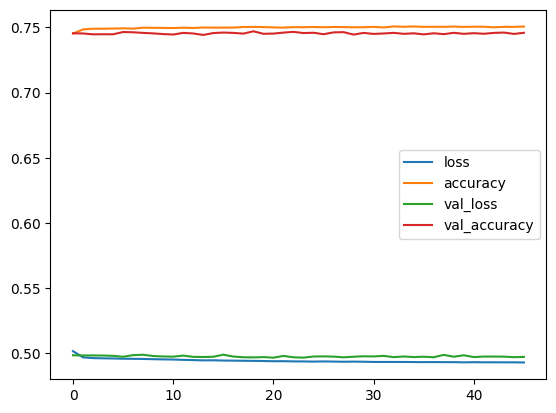

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the Model
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
model.fit(x=X_train_v2, y=Y_train_v2, epochs=600, validation_data=(X_test_v2, Y_test_v2), callbacks=[early_stop])

# Evaluate
losses = pd.DataFrame(model.history.history)
losses.plot()


In [ ]:
# Build functino for predicting a game
def predict_game(t1_id:int, t2_id:int, season:int, df:pd.DataFrame, scaler:StandardScaler, model:Sequential):
    diff_v1 = get_diff(df, t1_id, t2_id, season, FEATURES)
    diff_v2 = get_diff(df, t2_id, t1_id, season, FEATURES)

    diffs = scaler.transform([diff_v1, diff_v2])
    probs = model.predict(diffs)
    np.average(probs[0])
    return probs

print(predict_game(1104, 1113, 2024, df, V2_scaler, model))


In [39]:
# Save the classifier
import pickle
with open("../Models/clf_v2.pkl", "wb") as f:
    pickle.dump(clf_v2, f)

# Save the scaler
with open("../Models/scaler_v2.pkl", "wb") as f:
    pickle.dump(V2_scaler, f)

In [35]:
# Export the Neural Network Model
model.save("../Models/nn_model_v2.h5")
